In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.optimize import fsolve
import scipy as sc
import math
from pyteomics import pepxml
import random
import os
import glob
from collections import deque
import pickle
import importlib as imp
import lower as low
import param_estim as pe
imp.reload(low)
imp.reload(plt)
imp.reload(pe)
lows = low.Tools()
#lows.universal_ppf(0.7, 5, 0.1, 0.02)

1. Load the data
2. estimate the parameters from all lower orders by either MM or MLE
3. functionality to plot the estimated parameters (beta vs. mu, separate params against order index)
4. quantile optimization to find the best parameter mu for given order model (can be 1st, can be lower too)

In [185]:
def shift(arr, idx):
    return arr[idx] - arr[idx+1]

In [188]:
list(map(lambda x: shift(mms[:,0], x), range(9)))

[-0.028894771063093752,
 -0.04032244682142708,
 -0.056106093470427915,
 -0.07829286894109844,
 -0.0971331647551617,
 -0.11520498478966479,
 -0.13412845134328022,
 -0.1542828384118199,
 -0.17445909906407464]

LinregressResult(slope=0.5531024200986804, intercept=-0.05595440820111474, rvalue=0.9377678281337415, pvalue=6.084576113182941e-05, stderr=0.07241417469851484)


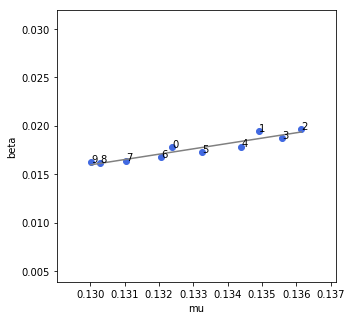

In [78]:
plot_params(n04, a4, 'MM_mubeta')

Text(0.5, 1.0, 'MM estimates, 3+')

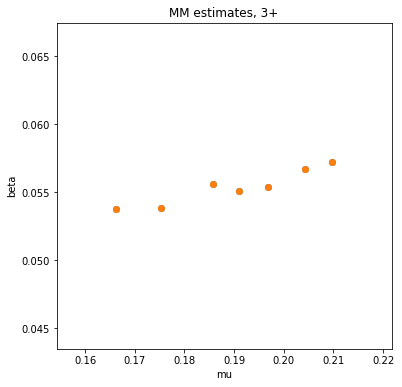

In [144]:
idx = 0
fig = plt.figure(figsize=(6,6))
plt.scatter(mms[:,0][3:], mms[:,1][3:])
plt.scatter(mms[:,0][3:], mms[:,1][3:])
#for x in range(len(mms[:,0][idx:])-1):
#    plt.annotate(x+idx+2, (mms[:,0][x+1]+0.000001, mms[:,1][x+1]+0.000001))
plt.xlabel("mu")
plt.ylabel('beta')
#plt.hlines(xmin=min(mms[:,0])-0.000001, xmax=max(mms[:,0])+0.000001, y=0.02, linestyles='--')
#plt.xlim(0.116, 0.118)
#plt.ylim(0.019, 0.0275)
plt.title("MM estimates, 3+")
#fig.savefig(f'./graphs/mm_estimates_ch3_gm.png', bbox_inches='tight', dpi=400)

In [2]:
#input: pepxml files, output: np arrays (TEV score, charge, N)

def parse_pepxmls(paths):

    tev = deque()
    charges = deque()
    big_n  = deque()

    for path in paths:
        print(path)
        cur_file = pepxml.read(path)

        for spec in cur_file:
            if 'search_hit' in spec.keys():
                if len(spec['search_hit']) == 10:
                    tev.append(list(map(lambda x: -0.02*np.log(spec['search_hit'][x]['search_score']['expect']/1000), np.arange(10))))
                    charges.append(int(spec['assumed_charge']))
                    big_n.append(int(spec['search_hit'][0]['num_matched_peptides']))

    return tev, charges, big_n

In [239]:
#parse the scores from the pepxml files
paths = glob.glob(os.path.join("/data/dominik/lower_order/datasets/mouse/", "*.pep.xml"))
paths
#test = pe.Estimation(paths)
#test.test_it(2)
tev, charges, big_n = parse_pepxmls(paths)

/data/dominik/lower_order/datasets/mouse/SORT_Prozac_1B.mzXML_18.pep.xml


In [5]:
pickle.dump(tev, open("tev_m.pkl", "wb"))
pickle.dump(charges, open("charges_m.pkl", "wb"))
pickle.dump(big_n, open("big_n_m.pkl", "wb"))

In [12]:
#get only tevs of selected charge

def filter_charge(tev, charges, big_n, ch):
    t = np.array(tev)
    c = np.array(charges)
    n = np.array(big_n)
    mask = np.where((c == ch))
    return t[mask], n[mask]


In [15]:
tev = pickle.load(open("tev_20.pkl", "rb"))
charges = pickle.load(open("charges_20.pkl", "rb"))
big_n = pickle.load(open("big_n_20.pkl", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: 'tev_20.pkl'

In [ ]:
new_tev = list(map(lambda x: -0.02*np.log(500*np.exp(-x/-0.02)/10), tev3))

In [ ]:
new_tev = -0.02*np.log(500*np.exp(-tev3/0.02)/10)

In [240]:

tev3, n3  = filter_charge(tev, charges, big_n, 3)
tev2, n2  = filter_charge(tev, charges, big_n, 2)
tev4, n4  = filter_charge(tev, charges, big_n, 4)

In [16]:
len(tev4)

679

In [ ]:
pickle.dump(big_n, open("big_n_dhp.pkl", "wb"))

In [17]:
#1 objective 1: estimate parameters for each hit separately, then plot the linear regression
def lower_params(arr):
    n0 = []
    a = []

    for hit in range(10):
        #if hit == 0: continue
        #print(hit)
        cur_tev = arr[:,hit].astype('float128')
        cur_tev = sorted(cur_tev)
        length = len(cur_tev)
        #cur_tev = cur_tev[int(length*0.05):int(length*0.95)]
        cur_n0, cur_a = lows.mle_new(cur_tev, hit)
        n0.append(cur_n0)
        a.append(cur_a)
    return n0, a

def plot_fitted( arr, N0, a, alpha, col='blue', frac=1, bins=500):
    sorted_arr = np.array(sorted(arr))
    l_lim = sorted_arr[0]
    u_lim = sorted_arr[-1]
    pdf = lows.pdf_mubeta(sorted_arr, N0, a, alpha)
    plt.plot(sorted_arr, frac*pdf,color=col)
    sns.distplot(sorted_arr, bins = np.linspace(0, 0.8, bins), kde=False, norm_hist=True,
                hist_kws=dict(histtype='step', linewidth=1, color='black'))
    #ax.set_xlim(l_lim, u_lim)
    plt.xlim(l_lim, u_lim)
    
    

def plot_fit(ax, arr, N0, a, alpha, col='blue', frac=1, bins=500):
    sorted_arr = np.array(sorted(arr))
    l_lim = sorted_arr[0]
    u_lim = sorted_arr[-1]
    pdf = lows.pdf_mubeta(sorted_arr, N0, a, alpha)
    ax.plot(sorted_arr, frac*pdf,color=col)
    ax.hist(sorted_arr, bins = np.linspace(0, 0.8, bins), histtype='step', density=True)
    median = np.median(sorted_arr)
    ax.vlines(x=median, ymin=0, ymax=20)
    #ax.set_xlim(l_lim, u_lim)
    ax.set_xlim(0, 0.3)

def plot_params(n0, a, outname = "", xxx=0):

    trim_n0 = list(n0)
    trim_a = list(a)
    linreg = st.linregress(trim_n0, trim_a)
    print(linreg)

    fig = plt.figure(figsize=(5,5))
    plt.scatter(trim_n0, trim_a, marker='o', color='royalblue')
    plt.plot([min(trim_n0), max(trim_n0)], 
                [min(trim_n0)*linreg.slope + linreg.intercept, 
                max(trim_n0)*linreg.slope + linreg.intercept], color='grey')
    plt.xlabel('mu')
    plt.ylabel("beta")
    plt.xlim(min(trim_n0)-0.001, max(trim_n0)+0.001)
    
    for x in range(len(trim_n0)):
        plt.annotate(x+xxx, (trim_n0[x]+0.00001, trim_a[x]+0.00003))
        
    #plt.hlines(xmin=min(trim_n0)-0.0001, xmax=max(trim_n0)+0.0001, y=0.02, linestyles='--')

    if outname != "":
        fig.savefig(f'./graphs/{outname}.png', bbox_inches='tight', dpi=400)

In [241]:
def get_params(tevs):
    n0, a = lower_params(tevs)
    trim_n0 = list(n0)[2:]
    trim_a = list(a)[2:]
    linreg = st.linregress(trim_n0, trim_a)

    return n0, a, linreg

n03, a3, linreg3 = get_params(tev3)
n02, a2, linreg2 = get_params(tev2)
n04, a4, linreg4 = get_params(tev4)
#linreg
#n1, a1 = np.log(np.log(n02)), np.log(-np.array(a2))


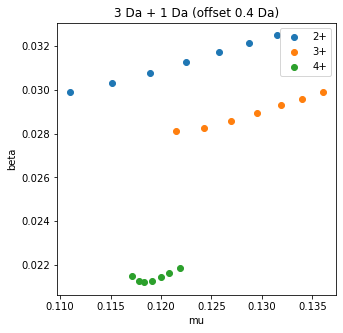

In [242]:
fig, ax = plt.subplots(figsize=(5,5))
x=3
ax.scatter(n02[x:], a2[x:])
ax.scatter(n03[x:], a3[x:])
#plt.scatter(best_mu, best_beta)
ax.scatter(n04[x:], a4[x:])
ax.set_xlabel("mu")
ax.set_ylabel("beta")
ax.set_title("3 Da + 1 Da (offset 0.4 Da)")
ax.legend(['2+', '3+', '4+'])
#ax.set_xlim(0.)
#fig.savefig('PT_26_3Da_1Da__scatter.png', dpi=400, bbox_inches='tight')
#plt.hlines(xmin=0.12, xmax=0.135, y=0.02)

In [20]:
opt_a  = np.mean([a4[-3:], a3[-3:]])

In [39]:
len(tev4)

0

In [269]:
def get_mm(tev):

    mms = np.zeros((10,2))

    for i in range(10):
        mms[i,:]= lows.mm_estimator(tev[:,i], i)
    return mms

m2 = get_mm(tev2)
m3 = get_mm(tev3)
m4 = get_mm(tev4)

(0.115, 0.12)

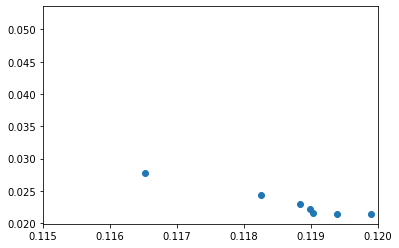

In [289]:
plt.scatter(mms[:,0], mms[:,1])
plt.xlim(0.115, 0.120)

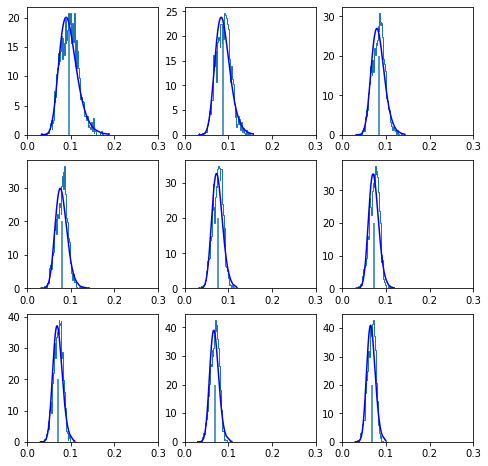

In [212]:
#plot_fitted(tev2[:,sss], n03[sss], a3[sss], sss, col='blue', frac=1, bins=1000)
fig, ax = plt.subplots(3,3, figsize=(8,8))
sss =1
for row in range(3):
    for col in range(3):
        plot_fit(ax[row%3, col],tev3[:,sss], n03[sss], a3[sss], sss, col='blue', frac=1, bins=500)
        sss += 1
#fig.savefig('smalltcells_ch2_lowerhits.png', dpi=400, bbox_inches='tight')
#plt.xlim(0, 0.2)

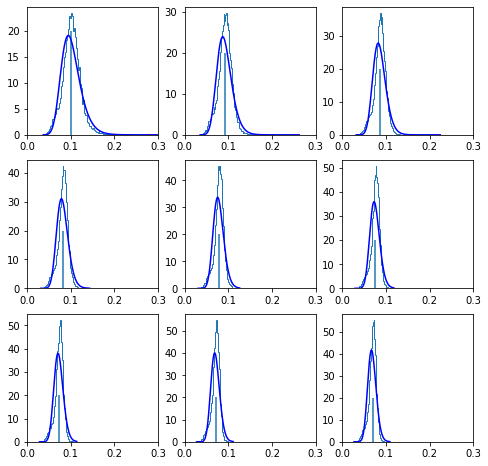

In [245]:
#plot_fitted(tev2[:,sss], n03[sss], a3[sss], sss, col='blue', frac=1, bins=1000)
fig, ax = plt.subplots(3,3, figsize=(8,8))
sss =1
for row in range(3):
    for col in range(3):
        plot_fit(ax[row%3, col],tev3[:,sss], n03[sss], a3[sss], sss, col='blue', frac=1, bins=500)
        sss += 1
#fig.savefig('yeast_3Da_1Da_f_lowerhits.png', dpi=400, bbox_inches='tight')
#plt.xlim(0, 0.2)

LinregressResult(slope=0.11841991752320757, intercept=0.016822258852427913, rvalue=0.9920276601349408, pvalue=1.2592067296676128e-06, stderr=0.006141379459760797, intercept_stderr=0.0007385232192472775)


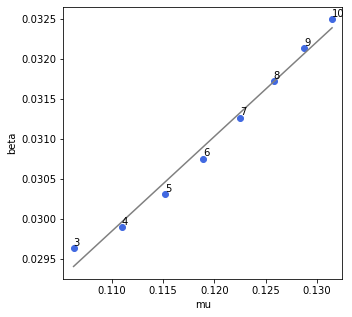

In [244]:
#plot_params(n02, a2)
nnn = 2
#plot_params(mms[:,0][nnn:], mms[:,1][nnn:], 'test', nnn+1)
plot_params(n02[nnn:], a2[nnn:], 'test', nnn+1)
#plt.scatter(best_mu, best_beta, marker="*")
#plt.savefig(f"./graphs/smalltcells_ch2_scatter.png", dpi=600,bbox_inches='tight')

In [51]:
best_beta

0.020003266329809807

In [ ]:
fig = plt.figure(figsize=(5,5))
sns.distplot(n3, bins = 50, kde=False, norm_hist=False,
                hist_kws=dict(histtype='stepfilled', linewidth=1, color='blue'))
plt.xlabel("# candidates for each spectrum")
plt.ylabel("counts")
plt.title("candidates for 3+ spectra")
plt.savefig(f"./graphs/n3.png", dpi=600,bbox_inches='tight')
#plt.xlim(0, 0.2)

In [ ]:
#plt.scatter(n022[2:], a22[2:])
fig = plt.figure(figsize=(6,6))
plt.scatter(n02[3:], a2[3:], marker="*")
plt.scatter(n03[3:], a3[3:], marker="*")
#plt.scatter(n044[3:], a44[3:], marker="*")
plt.legend(['2+', '3+', '4+'])
plt.xlabel("N0")
plt.ylabel("a")
#plt.savefig("./graphs/comparison_params.png", dpi=600, bbox_inches='tight')
#plt.scatter(n034[2:], a34[2:])

In [ ]:
from scipy.optimize import curve_fit

def test_function(x, a, b):
    #return np.multiply(np.power(x,0.5),a) + np.multiply(x, b) + c
    return a*np.log(x) + b

popt, pcov = curve_fit(test_function, range(1,10, n0all)
plt.plot(np.linspace(0,9, 100), test_function(np.linspace(0,9, 100), *popt))
plt.scatter(range(10), n0all)

In [29]:
def plot_sam(tev, n0, a, idx, tit, bins=800):
    fig = plt.figure(figsize=(6,6))
    cur_tev = tev[:,idx]
    plot_fitted(cur_tev, n0[idx], a[idx], alpha=idx, frac=1, bins=bins)
    #plt.xlim(0, 0.4)
    plt.xlabel("TEV")
    plt.text(x=0.15, y=15, s=f"N0: {n0[idx]:.3f}")
    plt.text(x=0.15, y=13, s=f"a: {a[idx]:.3f}")
    plt.ylabel("density")
    plt.title(f"{tit}")
    plt.savefig(f"./graphs/covid_{idx}_tev3_testing1.png", dpi=600, bbox_inches = 'tight')

/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

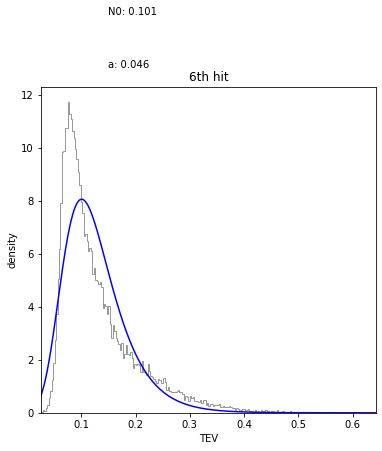

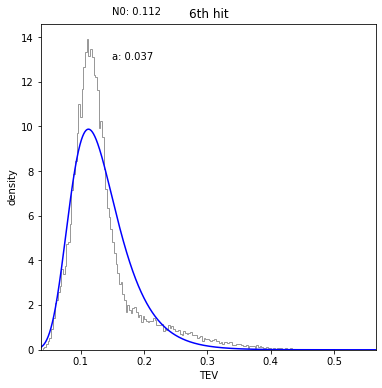

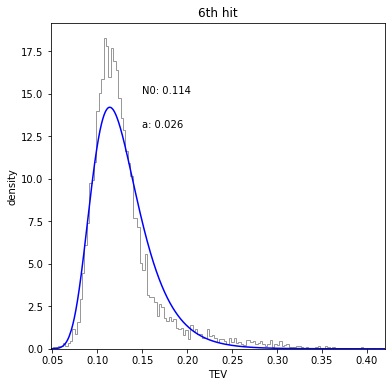

In [243]:
xxx = 0
plot_sam(tev2, n02, a2, xxx, '6th hit', bins=300)
plot_sam(tev3, n03, a3, xxx, '6th hit', bins=300)
plot_sam(tev4, n04, a4, xxx, '6th hit', bins=300)

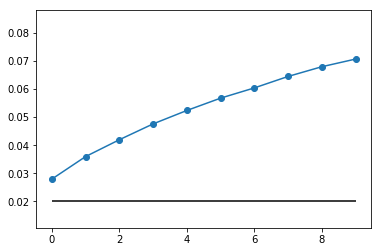

In [46]:
plt.scatter(np.arange(10), a2)
plt.plot(np.arange(10), a2)
plt.hlines(y=0.02, xmax=9, xmin=0)

In [233]:
np.log(1000)*0.02

0.13815510557964275

In [50]:
# generate quantiles
def get_quantiles(tev, outname):

    emps = sorted(tev)
    emps_df = pd.DataFrame(emps)

    emps_df[1] = emps_df.index + 1
    emps_df[2] = emps_df[1]/len(emps)

    #quantile optimization
    errors = []
    qq_range = np.linspace(50, 400, 1000)
    for i in qq_range:
        cur_a = i*linreg.slope + linreg.intercept
        theor_q = lows.gumbel_ppf(emps_df[2].to_numpy()[:-1], i, cur_a)
        diffs = theor_q - emps_df[0].to_numpy()[:-1]

        length = len(emps_df[2][emps_df[2] < 0.17])

        """
        diffs = abs(np.sum(diffs[:int(0.2*len(diffs))]))
        diffs = diffs/len(theor_q[:int(0.2*len(theor_q))])
        """

        diffs = abs(np.sum(diffs[:length]))
        diffs = diffs/len(theor_q[:length])

        #diffs = abs(np.sum(diffs))/len(diffs)
        errors.append(diffs)

    opt_idx = errors.index(min(errors))
    opt_N0 = qq_range[opt_idx]
    opt_a = opt_N0*linreg.slope + linreg.intercept

    fig = plt.figure(figsize=(6,6))
    plt.semilogy(qq_range, errors)
    plt.scatter(qq_range, errors, s=1)
    #plt.xlim(60,70)
    plt.xlabel("N0")
    plt.ylabel("loss")
    plt.savefig(f"./graphs/1{outname}.png", dpi=600, bbox_inches='tight')

    theor_q = lows.gumbel_ppf(emps_df[2].to_numpy()[:-1], opt_N0, opt_a)
    emps_q = emps_df[0].to_numpy()[:-1]

    fig1 = plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], color='k')
    plt.scatter(theor_q, emps_q, s=3)

    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
    plt.xlabel("theoretical quantile")
    plt.ylabel('empirical quantile')
    plt.savefig(f"./graphs/2{outname}.png", dpi=600, bbox_inches='tight')

    print(opt_N0, opt_a)

    

In [54]:
combined = lambda p: universal_ppf(p, 1, 0.1, 0.02)

In [146]:
# generate quantiles
def get_quantiles(tev, outname, opt_a, linreg):

    emps = sorted(tev)
    emps_df = pd.DataFrame(emps)

    emps_df[1] = emps_df.index + 1
    emps_df[2] = emps_df[1]/len(emps)

    #quantile optimization
    errors = []
    qq_range = np.linspace(0.05, 0.4, 500)
    #opt_a = np.mean(mms[:,1][-3:])
    for i in qq_range:
        #cur_a = i*linreg.slope + linreg.intercept
        cur_a = opt_a
        
        theor_q = lows.gumbel_new_ppf(emps_df[2].to_numpy()[:-1], i, cur_a)
        
        
        #print(i, cur_a)
        diffs = theor_q - emps_df[0].to_numpy()[:-1]

        length = len(emps_df[2][emps_df[2] < 0.2])
        
        """
        diffs = abs(np.sum(diffs[:int(0.2*len(diffs))]))
        diffs = diffs/len(theor_q[:int(0.2*len(theor_q))])
        """

        diffs = abs(np.sum(diffs[:length]))
        diffs = diffs/len(theor_q[:length])

        #diffs = abs(np.sum(diffs))/len(diffs)
        errors.append(diffs)

    opt_idx = errors.index(min(errors))
    opt_N0 = qq_range[opt_idx]
    #opt_a = opt_N0*linreg.slope + linreg.intercept
    fig = plt.figure(figsize=(6,6))
    plt.semilogy(qq_range, errors)
    plt.scatter(qq_range, errors, s=1)
    #plt.xlim(60,70)
    plt.xlabel("mu")
    plt.ylabel("loss")
    plt.savefig(f"./graphs/1{outname}.png", dpi=600, bbox_inches='tight')

    theor_q = lows.gumbel_new_ppf(emps_df[2].to_numpy()[:-1], opt_N0, opt_a)
    emps_q = emps_df[0].to_numpy()[:-1]

    fig1 = plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], color='k')
    plt.scatter(theor_q, emps_q, s=2)

    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
    plt.xlabel("theoretical quantile")
    plt.ylabel('empirical quantile')
    plt.savefig(f"./graphs/2{outname}.png", dpi=600, bbox_inches='tight')
    print(opt_N0, opt_a)
    return opt_N0, opt_a

    

In [270]:
# generate quantiles
def get_quantiles(tev, outname, opt_a, linreg):

    emps = sorted(tev)
    emps_df = pd.DataFrame(emps)

    emps_df[1] = emps_df.index + 1
    emps_df[2] = emps_df[1]/len(emps)

    #quantile optimization
    errors = []
    qq_range = np.linspace(0.05, 0.4, 500)
    #opt_a = np.mean(mms[:,1][-3:])
    for i in qq_range:
        #cur_a = i*linreg.slope + linreg.intercept
        cur_a = opt_a
        theor_q = lows.gumbel_new_ppf(emps_df[2].to_numpy()[:-1], i, cur_a)
        #print(i, cur_a)
        diffs = theor_q - emps_df[0].to_numpy()[:-1]

        length = len(emps_df[2][emps_df[2] < 0.2])
        
        """
        diffs = abs(np.sum(diffs[:int(0.2*len(diffs))]))
        diffs = diffs/len(theor_q[:int(0.2*len(theor_q))])
        """

        diffs = abs(np.sum(diffs[:length]))
        diffs = diffs/len(theor_q[:length])

        #diffs = abs(np.sum(diffs))/len(diffs)
        errors.append(diffs)

    opt_idx = errors.index(min(errors))
    opt_N0 = qq_range[opt_idx]
    #opt_a = opt_N0*linreg.slope + linreg.intercept
    fig = plt.figure(figsize=(6,6))
    plt.semilogy(qq_range, errors)
    plt.scatter(qq_range, errors, s=1)
    #plt.xlim(60,70)
    plt.xlabel("mu")
    plt.ylabel("loss")
    plt.savefig(f"./graphs/1{outname}.png", dpi=600, bbox_inches='tight')

    theor_q = lows.gumbel_new_ppf(emps_df[2].to_numpy()[:-1], opt_N0, opt_a)
    emps_q = emps_df[0].to_numpy()[:-1]

    fig1 = plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], color='k')
    plt.scatter(theor_q, emps_q, s=2)

    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
    plt.xlabel("theoretical quantile")
    plt.ylabel('empirical quantile')
    plt.savefig(f"./graphs/2{outname}.png", dpi=600, bbox_inches='tight')
    print(opt_N0, opt_a)
    return opt_N0, opt_a

    

In [250]:
# generate quantiles
def get_quantiles(tev, outname, opt_a, linreg):

    emps = sorted(tev)
    emps_df = pd.DataFrame(emps)

    emps_df[1] = emps_df.index + 1
    emps_df[2] = emps_df[1]/len(emps)

    #quantile optimization
    errors = []
    qq_range = np.linspace(0.05, 0.4, 500)
    #opt_a = np.mean(mms[:,1][-3:])
    for i in qq_range:
        cur_a = i*linreg.slope + linreg.intercept
        #cur_a = opt_a
        theor_q = lows.gumbel_new_ppf(emps_df[2].to_numpy()[:-1], i, cur_a)
        #print(i, cur_a)
        diffs = theor_q - emps_df[0].to_numpy()[:-1]

        length = len(emps_df[2][emps_df[2] < 0.1])
        
        """
        diffs = abs(np.sum(diffs[:int(0.2*len(diffs))]))
        diffs = diffs/len(theor_q[:int(0.2*len(theor_q))])
        """

        diffs = abs(np.sum(diffs[:length]))
        diffs = diffs/len(theor_q[:length])

        #diffs = abs(np.sum(diffs))/len(diffs)
        errors.append(diffs)

    opt_idx = errors.index(min(errors))
    opt_N0 = qq_range[opt_idx]
    opt_a = opt_N0*linreg.slope + linreg.intercept
    fig = plt.figure(figsize=(6,6))
    plt.semilogy(qq_range, errors)
    plt.scatter(qq_range, errors, s=1)
    #plt.xlim(60,70)
    plt.xlabel("mu")
    plt.ylabel("loss")
    plt.savefig(f"./graphs/1{outname}.png", dpi=600, bbox_inches='tight')

    theor_q = lows.gumbel_new_ppf(emps_df[2].to_numpy()[:-1], opt_N0, opt_a)
    emps_q = emps_df[0].to_numpy()[:-1]

    fig1 = plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], color='k')
    plt.scatter(theor_q, emps_q, s=2)

    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
    plt.xlabel("theoretical quantile")
    plt.ylabel('empirical quantile')
    plt.savefig(f"./graphs/2{outname}.png", dpi=600, bbox_inches='tight')
    print(opt_N0, opt_a)
    return opt_N0, opt_a

    

0.11172344689378759 0.021515944288914766


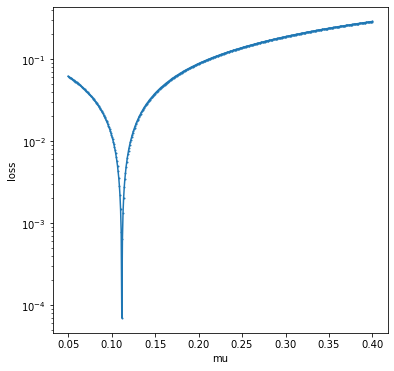

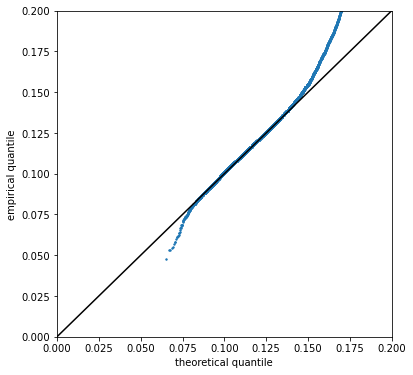

In [285]:
best_mu, best_beta = get_quantiles(tev4[:,0], 'test', np.mean(m4[:,1][-3:]), linreg3)

/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'density')

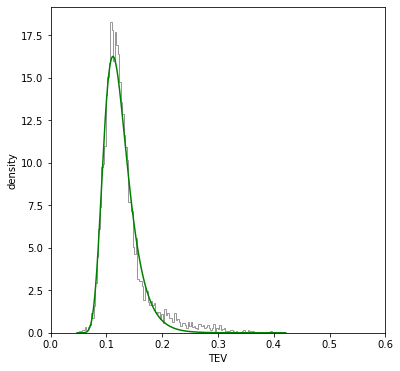

In [288]:
idx = 0
fig = plt.figure(figsize=(6,6))
#plot_fitted(tev3[:,idx], 323.3226452905812, -0.019269727693981706, idx, col='orange', frac=0.78)
#plot_fitted(tev3[:,idx], 387.3867735470942, -0.01798203934914556, idx, frac=0.72)
#plot_fitted(tev2[:,idx], 387.3867735470942, -0.01798203934914556, idx, frac=0.58)
#plot_fitted(tev2[:,idx], 57.0561122244489, -0.02925903843616671, idx, frac=1)

#plot_fitted(tev3[:,idx], 0.10350701402805612  , 0.02022161, idx, col='orange', frac=0.8)
plot_fitted(tev4[:,idx], best_mu , best_beta, idx, col='green', frac=0.95, bins=300)

#plot_fitted(tev3[:,idx], 355.3547094188377, -0.018625883521563632, idx, frac=0.75)
plt.xlim(0.0, 0.6)
plt.xlabel("TEV")
plt.ylabel("density")
#plt.legend(["", "theoretical"])
#plt.savefig("./graphs/fitted_PT_26_ch2_mean.png", dpi=600, bbox_inches="tight")

In [276]:
m3[:,1]

array([0.07337922, 0.03433709, 0.02967664, 0.02851138, 0.02796005,
       0.02787068, 0.02801653, 0.0282561 , 0.02846568, 0.02876657])

In [30]:
best_beta = np.mean(mms[:,1][7:])

In [108]:
pool = pd.read_csv("./scripts/pools_pep.csv", header=None)
pool.columns = ["file", "seq"]
pool = pool[pool.file.str.contains("_26")]
peptides = set(pool['seq'])

In [120]:
df_26 = det_fdr_prophet(paths[0], peptides)

In [197]:
def BH(df):
    
    ch2_mu = 0.12364729458917836 
    ch2_beta = 0.02430852610492772
    ch3_mu = 0.11733466933867737 
    ch3_beta = 0.026235996248217347
    
    pv = np.zeros(len(df.index))
    
    k=0
    for i in df.index:
        
        cur_ch = df.at[i, 'charge']
        cur_tev = df.at[i, 'TEV']
                
        if cur_ch == 2:
            p_v = 0.47*(1 - lows.mubeta_cdf(cur_tev, ch2_mu, ch2_beta))

        if cur_ch == 3:
            p_v = 0.8*(1 - lows.mubeta_cdf(cur_tev, ch3_mu, ch3_beta))
    
        pv[k] = p_v
        k += 1
    
    df['pv'] = pv
    df = df.sort_values("pv", ascending=True)
    df.reset_index(inplace=True, drop=True)
    df.index += 1
    #BH = pd.Series((df.index.to_series() * fdr) / len(df))
    #df['bh'] = BH
    #finaldf = df[df['PP_pval'] <= df['bh']]
    return df
    

In [199]:
new_df = BH(df_26)

In [180]:
new_df

,TEV,label,scan,charge,peptide,pv
1,0.454813,1.0,21470.0,2.0,HAQTVETLLR,0.000001
2,0.446654,1.0,21451.0,2.0,HAQTVETLLR,0.000002
3,0.442111,1.0,25360.0,2.0,VDCAFLDQPR,0.000002
4,0.438813,1.0,7767.0,2.0,GYDQSAYDGK,0.000002
5,0.436398,1.0,21516.0,2.0,HAQTVETLLR,0.000003
...,...,...,...,...,...,...
54557,0.050970,0.0,53783.0,2.0,KDLPFVEEIK,1.000000
54558,0.049491,0.0,23407.0,2.0,EQEIKLQK,1.000000
54559,0.049185,0.0,29696.0,2.0,STLDELLGR,1.000000
54560,0.048768,0.0,38726.0,2.0,EEAEEALK,1.000000


In [178]:
lows.mubeta_cdf(0.45813, 0.1236, 0.0243)

0.9999989499441363

In [181]:
def get_fdr(df, fdr):
    BH = pd.Series((df.index.to_series() * fdr) / len(df))
    df['bh'] = BH
    finaldf = df[df['pv'] <= df['bh']]
    return finaldf

In [186]:
w = get_fdr(new_df, 0.3)

In [187]:
len(w[w['label'] == 0])/len(w)

0.04113876881800566

In [200]:
sup = np.linspace(0.05, 0.3, 10)
fdps = []

for i in sup:
    w = get_fdr(new_df, i)
    fdps.append(len(w[w['label'] == 0])/len(w))

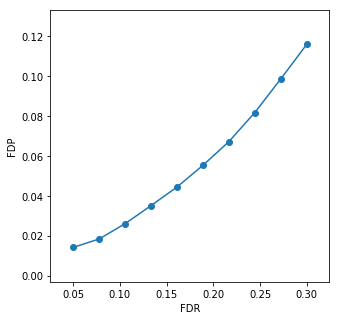

In [202]:
fig = plt.figure(figsize=(5,5))
plt.scatter(sup, fdps)
plt.plot(sup, fdps)
plt.xlabel("FDR")
plt.ylabel("FDP")
plt.savefig("./graphs/fdr_fdp_26_pi0_corrected.png", bbox_inches='tight', dpi=400)

In [127]:
def det_fdr_prophet(interactfile, ref_p):
    
    d = pepxml.read(interactfile)
    
    #pps = -1*np.ones(len(d))
    fvals = -1*np.ones(len(d))
    labels = np.zeros(len(d))
    charge = np.zeros(len(d))
    seqs = []
    specs = np.zeros(len(d))
                    
    
    k=0
    for el in d:
   
        if 'search_hit' in el.keys():
            #p_v = el['search_hit'][0]['analysis_result'][0]['peptideprophet_result']['probability']
            spec = el['start_scan']
            ch = int(el['assumed_charge'])
            pep = el['search_hit'][0]['peptide']
            fval = el['search_hit'][0]['search_score']['expect']
            fval = -0.02 * np.log(fval / 1000.)


            if pep in ref_p:
                label = 1
            else:
                label = 0
                
            fvals[k] = fval
            specs[k] = spec
            labels[k] = label
            charge[k] = ch
            seqs.append(pep)
          
            k +=1
            
    

    df = pd.DataFrame(np.array([fvals, labels, specs, charge]).T)
    df.columns = ['TEV', 'label', 'scan', 'charge']
    df = df[df['TEV'] != -1]
    df['peptide'] = seqs
    
    #df = df.sort_values('PP_pval', inplace=False, ascending=True)
    #df = df.reset_index(drop=True)
    #df.index += 1
    return df

In [ ]:
len(tev2[tev2[:,0] < 0.2][:,0])/len(tev2[:,0])

In [187]:
c = lambda x: 2*x

In [96]:
import scipy
from scipy.optimize import fsolve
import numpy as np
import math
p = 0.1
mu = 0.1
beta = 0.02
k=1
def universal_cdf(x):
        
        z = (x-mu)/beta
        f = lambda m: np.exp(-m*z)/math.factorial(m)
        summed = 0
        
        for i in range(k):
            #print(f(i))
            summed += f(i)
            
        #print(f"summed is {summed}")
        cdf = np.log(abs(p- np.exp(-np.exp(-z))*summed))

        return cdf
    
    
def universal_ppf(p, alpha, mu, beta):

    res = scipy.optimize.minimize(
    fun=lambda log_params, p, mu, beta, alpha: universal_cdf(log_params, p, mu, beta, alpha),
    x0=0.1,
    args=(p,mu, beta, alpha,),
       method='BFGS'

    )

    return res.x[0]

In [98]:
fsolve(universal_cdf, 0)

array([50.])

In [91]:
universal_ppf(0.4, 2, 0.1, 0.02)

0.08591515626126678

In [78]:
universal_cdf(0.10733025, 0.001, 0.1, 0.02, 1)

0.4989998542374931

In [ ]:
# investigate if mixing realization of RVs with different finite N will make a difference on the final distribution's parameters

def finite_gumbel_ppf(p, n0, n, a):
    q1 = n/n0
    q2 = 1 - np.power(p, 1/n)
    return a*np.log(q1*q2)

random.seed()
uni = st.uniform.rvs(0, 1, (200, 10000))
gf1 = finite_gumbel_ppf(uni, 500, 8000, -0.02)

random.seed()
uni = st.uniform.rvs(0, 1, (200, 10000))
gf2 = finite_gumbel_ppf(uni, 500, 16000, -0.02)

comb = list(map(lambda x: np.append(gf1[x], gf2[x]), np.arange(len(gf1))))
params = list(map(lambda x: lows.mle_universal(comb[x], 0), np.arange(len(comb))))



In [ ]:
single = st.uniform.rvs(0, 1, 10000)
final = list(map(lambda x: finite_gumbel_ppf(single, 500, x, -0.02), np.arange(8000, 40000, 200)))

In [ ]:
params = list(map(lambda x: lows.mle_universal(final[x], 0), np.arange(len(final))))

In [ ]:
first = list(map(lambda x: params[x][0], range(len(params))))
second = list(map(lambda x: params[x][1], range(len(params))))

In [ ]:
plt.hist2d(first, second, bins=(50,100))
plt.show()

In [ ]:
plt.scatter(first, second, s=1)
st.linregress(first, second)

In [ ]:
sns.distplot(n2)

In [ ]:
lows.mle_universal(comb, 0)

In [ ]:
comb = list(map(lambda x: np.append(gf1[x], gf2[x]), np.arange(len(gf1))))

In [ ]:
comb[0]